In [83]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow

In [84]:
import numpy as np
import pandas as pd

In [85]:
COMMODITY = 'copper'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (POUNDS)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/POUNDS)'
ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = '../volza/copper/copper.csv'
PRICE_FILE_PATH = "../volza/copper/copper_prices.csv"
EXPORT_PATH = '../metals/copper/copper_export.csv'
IMPORT_PATH = '../metals/copper/copper_import.csv'
GLOBAL_PATH = '../metals/copper/copper_global.csv'

In [86]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it. For VOLZA only.
def convert_to_pound(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185 * 2.20462,  
        'TNE': 1000 * 2.20462,     
        'KGS': 2.20462,            
        'Kgs': 2.20462,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Spike detection

In [87]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_pound(volza_pd)
volza_pd

,0,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (POUNDS),Std. Unit Rate ($/POUNDS)
0,1,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.007,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Lithuania T1 Import,1.399999e+01,5.537862
1,2,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.021,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Portugal T1 Import,4.199996e+01,65.516488
2,3,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.001,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,France T1 Import,1.999998e+00,10.110009
3,4,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.014,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Netherlands T1 Import,2.799997e+01,16.011086
4,5,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,21.809,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Belgium T1 Import,4.361796e+04,0.345750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32477,32478,2023-01-01,74020000,"COPPER , UNREFINED; COPPER ANODES FOR ELECTRO...",NaN,NaN,NaN,0.030,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Netherlands T1 Import,5.999995e+01,8.960508
32478,32479,2023-01-01,74020000,"COPPER , UNREFINED; COPPER ANODES FOR ELECTRO...",NaN,NaN,NaN,0.630,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Germany T1 Import,1.259999e+03,4.582695
32479,32480,2023-01-01,74020000,"COPPER , UNREFINED; COPPER ANODES FOR ELECTRO...",NaN,NaN,NaN,5357.720,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Belgium T1 Import,1.071543e+07,5.473429
32480,32481,2023-01-01,74020000,"COPPER , UNREFINED; COPPER ANODES FOR ELECTRO...",NaN,NaN,NaN,239.670,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Hungary T1 Import,4.793396e+05,3.780695


In [88]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].astype(float)  # Assuming no commas in the price column
prices_pd = prices_pd[['Date', 'Price']]
prices_pd

,Date,Price
0,2022-12-30,3.8055
1,2022-12-29,3.8210
2,2022-12-28,3.8320
3,2022-12-27,3.8335
4,2022-12-23,3.8030
...,...,...
1003,2019-01-08,2.6605
1004,2019-01-07,2.6410
1005,2019-01-04,2.6515
1006,2019-01-03,2.5705


In [89]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[['Value',QUANTITY_COLUMN,'Gross Weight']].sum()

In [90]:
prices_pd = prices_pd.set_index('Date')
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')

C:\Users\manim\AppData\Local\Temp\ipykernel_10564\3127498705.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')


In [91]:
## Detecting spikes
window_size = 20  # Adjust the window size based on your data
moving_avg = aggregated_df['Price'].rolling(window=window_size).mean()
std_dev = aggregated_df['Price'].rolling(window=window_size).std()

# Set a threshold to identify spikes
threshold = 2  # You can adjust this value based on your data
spikes = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev)
aggregated_df['spikes'] = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev).astype(int)

In [92]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Value,Std. Quantity (POUNDS),Gross Weight,Price,spikes
Date,,,,,
2019-01-01,3.580679e+08,1.115013e+08,512426.9,NaN,0
2019-01-02,2.899774e+07,9.930702e+06,4507752.0,2.6250,0
2019-01-03,1.652543e+07,5.351697e+06,2428782.0,2.5705,0
2019-01-04,1.381037e+05,4.362061e+04,0.0,2.6515,0
2019-01-06,1.854971e+07,6.670174e+06,0.0,2.6515,0
...,...,...,...,...,...
2022-12-28,3.660210e+07,1.011938e+07,2301364.0,3.8320,0
2022-12-29,9.597299e+06,5.367289e+06,2415.6,3.8210,0
2022-12-30,1.148950e+08,5.010989e+06,360.0,3.8055,0


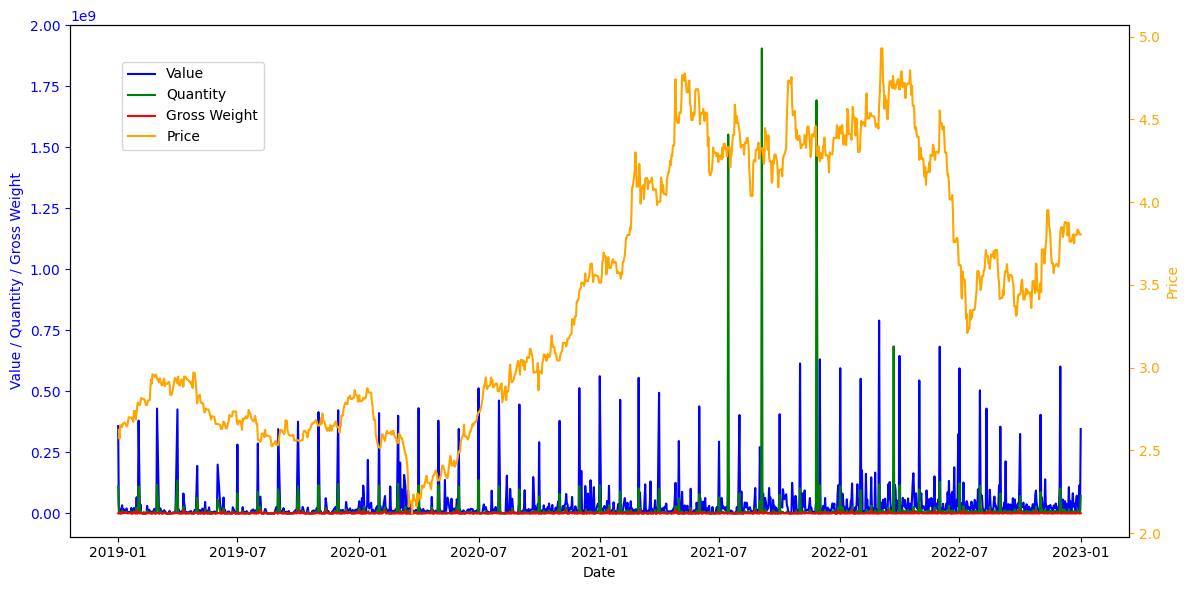

In [93]:
#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df['Value'], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df['Gross Weight'], label='Gross Weight', color='r')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

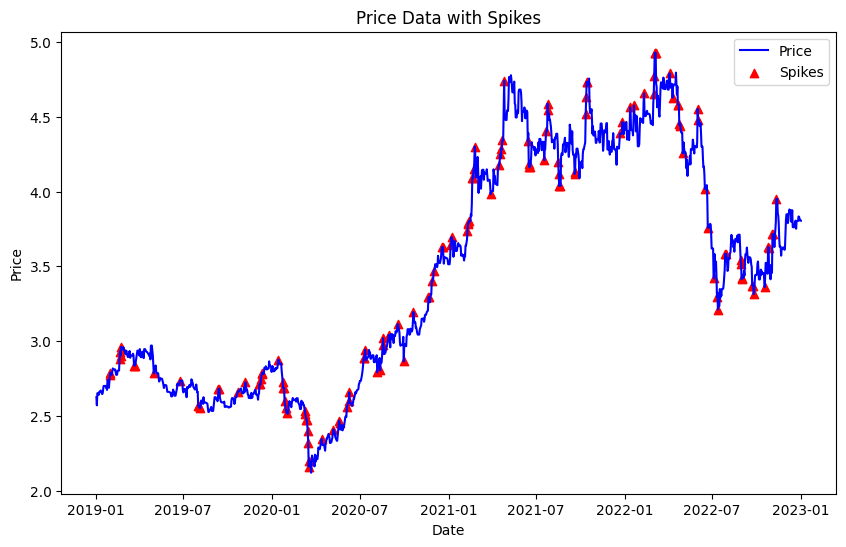

In [94]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

## Data Prep for Classification

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

time_series_df = aggregated_df.copy()
time_series_df = time_series_df.dropna()

# Drop rows with NaN in the 'spikes' column
time_series_df = time_series_df.dropna(subset=['spikes'])

# Extract features and target variable
X = time_series_df[['Value', QUANTITY_COLUMN, 'Gross Weight', 'Price']].values
y = time_series_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 20
window_size = 20
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - window_size + 1):
    X_sequences.append(X_scaled[i:i + window_size, :])
    y_sequences.append(y[i + window_size - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50)

In [96]:
def make_output_dict(name, params, classification_report):
    return {
        "name": name,
        "params": params,
        "accuracy": classification_report["accuracy"],
        "precision (0)": classification_report["0"]["precision"],
        "recall (0)": classification_report["0"]["recall"],
        "f1 (0)": classification_report["0"]["f1-score"],
        "precision (1)": classification_report["1"]["precision"],
        "recall (1)": classification_report["1"]["recall"],
        "f1 (1)": classification_report["1"]["f1-score"],
    }

output_dicts = []

In [97]:
#LSTM Model
def evaluate_lstm(num_layers: int):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(num_layers, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


  y_pred = (model.predict(X_test) > 0.5).astype(int)


  # Generate confusion matrix
  # conf_matrix = confusion_matrix(y_test, y_pred)

  # # Calculate accuracy
  # accuracy = accuracy_score(y_test, y_pred)

  # Display confusion matrix
  # plt.figure(figsize=(6, 6))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
  #             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
  # plt.show()

  return make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True))


In [98]:
def evaluate_rnn(num_units: int):
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("RNN", f"{num_units} units", classification_report(y_test, y_pred, output_dict=True))

In [99]:
def evaluate_cnn(num_filters: int, kernel_size: int):
    # Build the CNN model
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("CNN", f"{num_filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred, output_dict=True))


## LSTM (100 layers)

In [100]:
#LSTM Model

output_dicts.append(evaluate_lstm(250))
output_dicts.append(evaluate_lstm(200))
output_dicts.append(evaluate_lstm(100))
output_dicts.append(evaluate_lstm(50))

# Build the LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# # Train the model
# print(X_train.shape)
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


# y_pred = (model.predict(X_test) > 0.5).astype(int)


# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("LSTM (100 layers)", "", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


8/8 [==============================] - 0s 2ms/step


In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


def evaluate_random_forest(n_estimators):
  # Create a Random Forest Classifier
  random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

  X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
  X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

  # Train the classifier
  random_forest.fit(X_train_reshaped, y_train)

  # Make predictions on the test set
  y_pred = random_forest.predict(X_test_reshaped)

  # Generate confusion matrix
  # conf_matrix = confusion_matrix(y_test, y_pred)

  # # Calculate accuracy
  # accuracy = accuracy_score(y_test, y_pred)
  return make_output_dict("Random Forest", f"{n_estimators} Estimators", classification_report(y_test, y_pred, output_dict=True))

  # Display confusion matrix
  # plt.figure(figsize=(6, 6))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
  #             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
  # plt.show()


## Attention

In [102]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

def create_model(input_shape, num_classes, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Reshape for attention
    reshape = Reshape((-1, 64))(pool1)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_attention_cnn(filters, kernel_size):
    model = create_model(X_train.shape[1:], 2, filters, kernel_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=filters, verbose=False)
    y_pred = model.predict(X_test)
    return make_output_dict("CNN with Attention", "", classification_report(y_test, y_pred.argmax(axis=1), output_dict=True))

output_dicts.append(evaluate_attention_cnn(32, 5))
output_dicts.append(evaluate_attention_cnn(64, 5))
output_dicts.append(evaluate_attention_cnn(128, 5))
output_dicts.append(evaluate_attention_cnn(256, 5))
output_dicts.append(evaluate_attention_cnn(64, 3))
output_dicts.append(evaluate_attention_cnn(128, 3))
output_dicts.append(evaluate_attention_cnn(256, 3))


8/8 [==============================] - 0s 2ms/step


## Random Forrest Classifier

In [103]:
output_dicts.append(evaluate_random_forest(50))
output_dicts.append(evaluate_random_forest(25))
output_dicts.append(evaluate_random_forest(20))
output_dicts.append(evaluate_random_forest(10))
output_dicts.append(evaluate_random_forest(5))

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Create a Random Forest Classifier
# random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# # Train the classifier
# random_forest.fit(X_train_reshaped, y_train)

# # Make predictions on the test set
# y_pred = random_forest.predict(X_test_reshaped)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# output_dicts.append(make_output_dict("Random Forest", f"", classification_report(y_test, y_pred, output_dict=True)))

# # Display confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
# plt.show()


## RNN

In [104]:
output_dicts.append(evaluate_rnn(200))
output_dicts.append(evaluate_rnn(150))
output_dicts.append(evaluate_rnn(100))
output_dicts.append(evaluate_rnn(50))


8/8 [==============================] - 0s 2ms/step


## CNN

In [105]:
output_dicts.append(evaluate_cnn(64, 3))
output_dicts.append(evaluate_cnn(128, 3))
output_dicts.append(evaluate_cnn(256, 3))
output_dicts.append(evaluate_cnn(64, 5))
output_dicts.append(evaluate_cnn(128, 5))
output_dicts.append(evaluate_cnn(256, 5))

8/8 [==============================] - 0s 1ms/step


In [106]:
output_dicts = pd.DataFrame(output_dicts)
output_dicts.to_csv(f"{COMMODITY}_model_performance.csv")
output_dicts

,name,params,accuracy,precision (0),recall (0),f1 (0),precision (1),recall (1),f1 (1)
0,LSTM,250 layers,0.885246,0.924107,0.949541,0.936652,0.450000,0.346154,0.391304
1,LSTM,200 layers,0.877049,0.923423,0.940367,0.931818,0.409091,0.346154,0.375000
2,LSTM,100 layers,0.901639,0.936937,0.954128,0.945455,0.545455,0.461538,0.500000
3,LSTM,50 layers,0.897541,0.917749,0.972477,0.944321,0.538462,0.269231,0.358974
4,CNN with Attention,,0.872951,0.908297,0.954128,0.930649,0.333333,0.192308,0.243902
5,CNN with Attention,,0.868852,0.897436,0.963303,0.929204,0.200000,0.076923,0.111111
6,CNN with Attention,,0.868852,0.904348,0.954128,0.928571,0.285714,0.153846,0.200000
7,CNN with Attention,,0.897541,0.897119,1.000000,0.945770,1.000000,0.038462,0.074074
8,CNN with Attention,,0.840164,0.894273,0.931193,0.912360,0.117647,0.076923,0.093023
9,CNN with Attention,,0.885246,0.913043,0.963303,0.937500,0.428571,0.230769,0.300000


## OEC Trade Data

In [107]:
# oed_data = spark.read.csv("/Users/harshdeepsingh/Downloads/trade_i_baci_a_12.tsv", header=True, sep="\t")

In [108]:
# oed_data.printSchema()
# magnesium_data = oed_data.filter(col("hs_code").like("8104%"))

In [109]:
# exported_mag_data = oed_data.groupBy("year","exporter_name").agg(F.sum("value").alias("export_value"),F.sum("quantity").alias("export_quantity"))

In [110]:
# temp = exported_mag_data.withColumn("mag_price_calc", col("export_value")/col("export_quantity")).orderBy("year")

In [111]:
# temp.filter("exporter_name == 'China'").show()